# This Assignment was done by :
### Mahmoud Labib Elsamadony____20208029
### Ahmed Alaa Elsaadani____20208003
### Abdelrahman Mezar____20208018
### Mohamed Amr Shehab___20208041
### Mohamed Ahmed Seif___20208025

# RSNA Pneumonia Detection
1- The dataset provided in two folder:
- train_images.zip
- test_images.zip.

</br>

2- train.csv:
- the training set. Contains patientIds and bounding box / target information.
- patientId :- A patientId. Each patientId corresponds to a unique image.
- x :- the upper-left x coordinate of the bounding box.
- y :- the upper-left y coordinate of the bounding box.
- width :-the width of the bounding box.
- height :- the height of the bounding box.
- Target :- the binary Target, indicating whether this sample has evidence of pneumonia

## First we view the data 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydicom
from PIL import Image
import os
from ultralytics import YOLO

In [2]:
df = pd.read_csv('dataset/train_labels.csv')
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [3]:
# replace nans with 0
df.fillna(0, inplace=True)
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [4]:
df.describe()

,x,y,width,height,Target
count,30227.000000,30227.000000,30227.000000,30227.000000,30227.000000
mean,124.561683,115.960962,69.060575,104.084825,0.316108
std,216.326397,190.012883,106.910496,176.932152,0.464963
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,193.000000,231.000000,169.000000,188.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


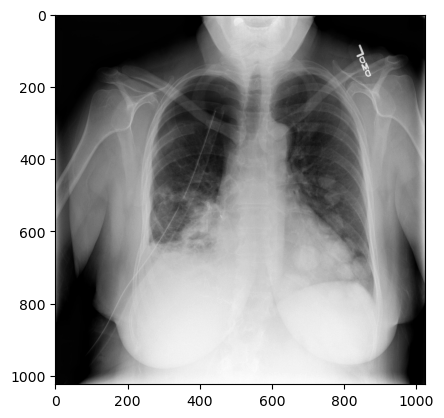

In [5]:
# Plotting the first image

path_to_image = df['patientId'][0]

# Load the .dcm image
ds = pydicom.dcmread(f'dataset/train_images/{path_to_image}.dcm')

# Access image data
image = ds.pixel_array

# Display the image
plt.imshow(image, cmap='gray')
plt.show()

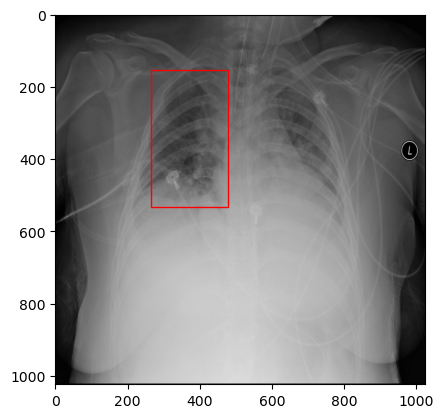

In [6]:
# Plotting the first image with bounding box

# Load the .dcm image
path_to_image = df['patientId'][4]
ds = pydicom.dcmread(f'dataset/train_images/{path_to_image}.dcm')

# Access image data
image = ds.pixel_array

# Display the image
plt.imshow(image, cmap='gray')

# Add bounding box

# Get the target values
x = df['x'][4]
y = df['y'][4]
width = df['width'][4]
height = df['height'][4]

# Create a Rectangle patch

rect = plt.Rectangle((x, y), width, height, edgecolor='r', facecolor='none')

# Add the patch to the Axes
plt.gca().add_patch(rect)

plt.show()

Target
0    20672
1     9555
Name: count, dtype: int64


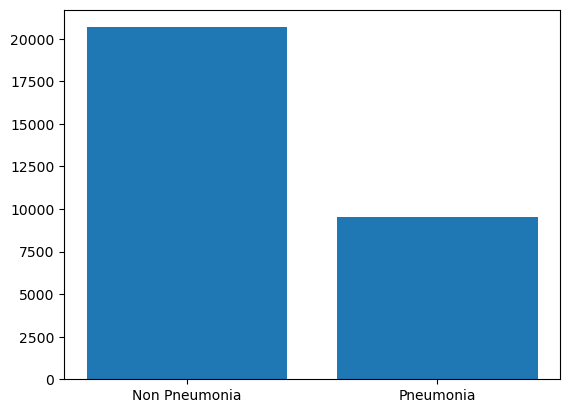

In [7]:
# compare between the number of images with pneumonia and without pneumonia
print(df['Target'].value_counts())
plt.bar(['Non Pneumonia', 'Pneumonia'], df['Target'].value_counts());

In [8]:
# count the .dcm files in the dataset/train_images folder
print(len(os.listdir('dataset/train_images')))

26684


In [9]:
# check if any of the patientId in the train_labels.csv file are in the dataset/test_images folder
test_images = os.listdir('dataset/test_images')

for patientId in df['patientId']:
    if f'{patientId}.dcm' in test_images:
        print(patientId)

In [10]:
df.shape

(30227, 6)

In [11]:
# count the number of unique patients
df['patientId'].nunique()

26684

In [12]:
print(len(os.listdir('dataset/test_images')))

3000


- Nan values are replaced with zeros
- number of images with non-pneumonia are double the images with pneumonia (imbalanced data)
- number of unique patients in the dataframe is equal to the number of training images (no redundancy)

## Convert the .dcm images to a format that YOLOv8 can work with

- First, we extract the image data from .dcm file
- Second, we will Normalize the pixel values to be from 0 - 255 (leading to faster convergence)
- we then convert it to jpg format

In [13]:
# convert the .dcm files to .jpg files

def convert_dcm_to_jpg(input_folder, output_folder):
    for file in os.listdir(input_folder):
        if os.path.isfile(f'{output_folder}/{file.split(".")[0]}.jpg'):
            continue
        ds = pydicom.dcmread(f'{input_folder}/{file}')
        img = ds.pixel_array
        # Normalize the pixel values to the range [0, 255]
        image_normalized = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
        image_normalized = image_normalized.astype(np.uint8)  # Convert to unsigned 8-bit integer type

        # Convert the numpy array to a PIL image
        image = Image.fromarray(image_normalized)

        filename = file.split('.')[0]
        image.save(f'{output_folder}/{filename}.jpg')

In [9]:
convert_dcm_to_jpg('dataset/train_images', 'dataset/images/train')

In [11]:
convert_dcm_to_jpg('dataset/test_images', 'dataset/images/test')

## Normalizing the labels (YOLO Format)

In [14]:
def normalize_bboxs(df):
    img_size = 1024 
    
    # normalize the bounding boxes
    df['width'] = df['width'] / img_size
    df['height'] = df['height'] / img_size
    # Centering X , Y coordinates and normalize them
    df['x'] = df['x'] / img_size + df['width'] / 2
    df['y'] = df['y'] / img_size + df['height'] / 2

    
def denormalize_bbox(rx, ry, rw, rh):
    img_size = 1024 
    
    x = (rx-rw/2)*img_size
    y = (ry-rh/2)*img_size
    w = rw*img_size
    h = rh*img_size
    
    return x, y, w, h

In [15]:
normalize_bboxs(df)

df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.000000,0.000000,0.000000,0.000000,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.000000,0.000000,0.000000,0.000000,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.000000,0.000000,0.000000,0.000000,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.000000,0.000000,0.000000,0.000000,0
4,00436515-870c-4b36-a041-de91049b9ab4,0.361816,0.333496,0.208008,0.370117,1


## Preparing The labels folder

In [16]:
# Converting the df to .txt files per patientId each patientId in separate file (as there might be multiple bounding boxes per patientId)

def convert_df_to_txt_files(df, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for patientId in df['patientId'].unique():
        patient_df = df[df['patientId'] == patientId].copy()
        if patient_df['Target'].values[0] == 0:
            # if the patient doesn't have pneumonia, output empty txt file
            with open(f'{output_folder}/{patientId}.txt', 'w') as f:
                f.close()
            continue
        patient_df.drop(columns='patientId', inplace=True)
        # getting the target column to the first column
        cols = patient_df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        patient_df = patient_df[cols]
        patient_df['Target'] = 0
        patient_df.to_csv(f'{output_folder}/{patientId}.txt', index=False, header=False, sep=' ')


In [ ]:
convert_df_to_txt_files(df, 'dataset/labels/train')

## Splitting the data into train_1 , train_2 , train_3 and validation (Hardware constraints)

In [16]:
## split the data into train_1 , train_2 , train_3 and validation sets and without shuffling the patientIds

# get the unique patientIds
patientIds = df['patientId'].unique()

train_1 = patientIds[:9000]
train_2 = patientIds[9000:18000]
train_3 = patientIds[18000:24000]
validation = patientIds[24000:]

# get the patientIds for each set
train_1_df = df[df['patientId'].isin(train_1)].copy()
train_2_df = df[df['patientId'].isin(train_2)].copy()
train_3_df = df[df['patientId'].isin(train_3)].copy()
validation_df = df[df['patientId'].isin(validation)].copy()


# convert the train_1_df, train_2_df, train_3_df and validation_df to .txt files
# convert_df_to_txt_files(train_1_df, 'dataset/labels/train_1')
# convert_df_to_txt_files(train_2_df, 'dataset/labels/train_2')
# convert_df_to_txt_files(train_3_df, 'dataset/labels/train_3')
# convert_df_to_txt_files(validation_df, 'dataset/labels/validation')

# copy the images to the respective folders
def copy_images_to_folder(df, input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for patientId in df['patientId'].unique():
        os.system(f'cp {input_folder}/{patientId}.jpg {output_folder}/{patientId}.jpg')

# copy_images_to_folder(train_1_df, 'dataset/images/train', 'dataset/images/train_1')
# copy_images_to_folder(train_2_df, 'dataset/images/train', 'dataset/images/train_2')
# copy_images_to_folder(train_3_df, 'dataset/images/train', 'dataset/images/train_3')
# copy_images_to_folder(validation_df, 'dataset/images/train', 'dataset/images/validation')



## Training The YOLOv8 Algorithm 

- we ran each part `(train_1 , train_2 , train_3)` of the data for two epochs to achieve better results 
- at the end of each part we get the `best.pt` from the previous one for the next training session
- that lead to better losses , precision and recall

In [5]:
model = YOLO("dataset/best3.pt")

res = model.train(data="data.yaml", epochs=1) # one final epoch to finish training

New https://pypi.org/project/ultralytics/8.2.19 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.18 🚀 Python-3.11.5 torch-2.2.2 CUDA:0 (NVIDIA GeForce GTX 1650, 3904MiB)
engine/trainer: task=detect, mode=train, model=dataset/best3.pt, data=data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=

train: Scanning /media/mahmoud/31A5D0D7034B3BD5/General/FCAI/8th Term/Assignment_1/dataset/labels/train_1.cache... 9000 images, 6932 backgrounds, 0 corrupt: 100%|██████████| 9000/9000 [00:00<?, ?it/s]
val: Scanning /media/mahmoud/31A5D0D7034B3BD5/General/FCAI/8th Term/Assignment_1/dataset/labels/validation.cache... 2684 images, 2079 backgrounds, 0 corrupt: 100%|██████████| 2684/2684 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.31G      2.032      2.694      1.866          1        640: 100%|██████████| 563/563 [08:51<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [00:59<00:00,  1.42it/s]


                   all       2684        981      0.153      0.243      0.108     0.0331

1 epochs completed in 0.167 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.18 🚀 Python-3.11.5 torch-2.2.2 CUDA:0 (NVIDIA GeForce GTX 1650, 3904MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [00:51<00:00,  1.62it/s]


                   all       2684        981      0.157      0.224      0.109     0.0337
Speed: 0.4ms preprocess, 17.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


## Predicting Bounding Boxes

In [2]:
model = YOLO("best3.pt")
results = model('dataset/images/test',conf=0.1,stream=True)

def get_id_from_path(path):
    return os.path.splitext(os.path.basename(path))[0]

for result in results:
    id = get_id_from_path(result.path)
    with open(f'dataset/predictions/{id}.txt', 'w') as f:
        if len(result.xywh) == 0:
            f.write(f'{id}\n')
        else:
            with open(f'dataset/predictions/{id}.txt', 'w') as f:
                
                x, y, w, h = denormalize_bbox(*result.xywh.tolist())
                confidence = result.conf
                f.write(f'{id} {confidence} {x} {y} {w} {h} \n')
